### Student Information
Name: 黃玄彰

Student ID: 110030031

GitHub ID: pigerface@gmail.com

Kaggle name: pigerface

Kaggle private scoreboard snapshot: 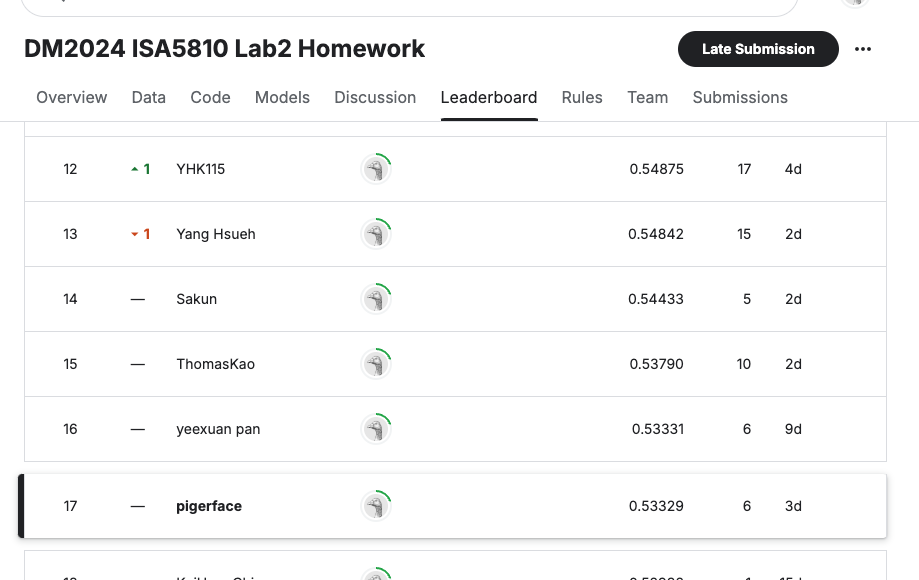

# 2. Model Developing Report


## 2.1 Import Libraries

In [1]:
import json
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, precision_score, recall_score
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import re
import emoji
from transformers import TrainingArguments, EarlyStoppingCallback
from transformers import Trainer, TrainingArguments
import os

2024-12-07 03:36:11.855987: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-07 03:36:12.274469: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733513772.443257   10048 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733513772.492846   10048 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-07 03:36:12.901112: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## 2.2 Data Loading and Preprocessing

### 2.2.1 Load Data from Files

In [2]:
def load_data(emotion_path, data_identification_path, tweets_path):
    """
    Function to load and process data
    :param emotion_path: str, path to emotion.csv file
    :param data_identification_path: str, path to data_identification.csv file 
    :param tweets_path: str, path to tweets_DM.json file
    :return: pd.DataFrame, pd.DataFrame, pd.DataFrame
    """
    # Read emotion and data_identification data
    emotion = pd.read_csv(emotion_path)
    data_identification = pd.read_csv(data_identification_path)

    # Read tweets_DM.json and parse into DataFrame
    with open(tweets_path, 'r') as f:
        data = [json.loads(line) for line in f]

    df = pd.DataFrame(data)
    _source = df['_source'].apply(lambda x: x['tweet'])
    df = pd.DataFrame({
        'tweet_id': _source.apply(lambda x: x['tweet_id']),
        'hashtags': _source.apply(lambda x: x['hashtags']), 
        'text': _source.apply(lambda x: x['text']),
    })
    
    # Merge with data_identification
    df = df.merge(data_identification, on='tweet_id', how='left')

    return df, emotion, data_identification

### 2.2.2 Clean Text 
(I didn't use this function in the final version since it's performed better without cleaning)

In [3]:
def clean_text(text):
    """
    Helper function to clean text
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove @mentions
    text = re.sub(r'@\w+', '', text)
    
    # Convert emojis to text descriptions
    text = emoji.demojize(text)
    
    # Remove special characters but keep emoji descriptions (text between colons)
    text = re.sub(r'[^\w\s:_-]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

### 2.2.3 Preprocess Data


* Use tokenizer (in this case, I use roberta-base) to tokenize the text

* Split the data into train and test sets
* Use label encoder (in this case, I use sklearn.preprocessing.LabelEncoder) to encode the labels

In [4]:
def preprocess_data(df, emotion, label_encoder, tokenizer, clean_func=clean_text):
    """
    Process data, split into train/test sets, and perform tokenization
    """
    # Tokenization function
    def tokenize_function(text):
        return tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')

    # Split datasets
    train_data = df[df['identification'] == 'train']
    test_data = df[df['identification'] == 'test']
    
    # # Clean text before splitting datasets
    # (I didn't use this function in the final version since it's performed better without cleaning)
    # train_data['text'] = train_data['text'].apply(clean_func)
    # test_data['text'] = test_data['text'].apply(clean_func)

    # Merge emotion with training set
    train_data = train_data.merge(emotion, on='tweet_id', how='left')
    train_data.drop_duplicates(subset=['text'], keep=False, inplace=True)

    # Split into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        train_data['text'], train_data['emotion'], test_size=0.2, random_state=42, stratify=train_data['emotion']
    )

    # Reset index
    y_train.reset_index(drop=True, inplace=True)
    y_val.reset_index(drop=True, inplace=True)
    
    # Label Encoding
    y_train = label_encoder.fit_transform(y_train)
    y_val = label_encoder.transform(y_val)
    
    # Tokenize train and validation sets
    X_train_tokenized = X_train.apply(tokenize_function)
    X_val_tokenized = X_val.apply(tokenize_function)
    test_data_tokenized = test_data['text'].apply(tokenize_function)
    

    return train_data, test_data, X_train_tokenized, X_val_tokenized, y_train, y_val, test_data_tokenized

### 2.2.4 Dataset Preparation

* Convert the tokenized texts into dictionaries to enable the use of torch.utils.data.Dataset

* Create a custom dataset (inherit from torch.utils.data.Dataset) class for the training, validation, and test sets

In [5]:
def convert_to_dicts(tokenized_texts):
    # Modify conversion method to ensure correct tensor format
    input_ids = []
    attention_masks = []
    
    for text in tokenized_texts:
        # Remove extra dimensions
        input_ids.append(text['input_ids'].squeeze(0))
        attention_masks.append(text['attention_mask'].squeeze(0))
    
    return {
        'input_ids': torch.stack(input_ids),
        'attention_mask': torch.stack(attention_masks)
    }
    
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {
                'input_ids': self.encodings['input_ids'][idx],
                'attention_mask': self.encodings['attention_mask'][idx],
                'labels': torch.tensor(self.labels[idx])
            }
        return item

### 2.2.5 Execute the Preprocessing Steps

In [6]:
# Choose the data path up to the environment
# data_base_path = '/kaggle/input/dm-2024-isa-5810-lab-2-homework/'
data_base_path = './data/'
emotion_path = data_base_path + 'emotion.csv'
data_identification_path = data_base_path + 'data_identification.csv'
tweets_path = data_base_path + 'tweets_DM.json'

# Initialize tokenizer and label encoder
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
label_encoder = LabelEncoder()

# Load and process data
df, emotion, data_identification = load_data(emotion_path, data_identification_path, tweets_path)
train_data, test_data, X_train, X_val, y_train, y_val, test_data_tokenized = preprocess_data(df, emotion, label_encoder, tokenizer)

print("Data loading and processing completed!")
print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

# Convert to lists of dictionaries
train_encodings = convert_to_dicts(X_train)
val_encodings = convert_to_dicts(X_val)
test_encodings = convert_to_dicts(test_data_tokenized)

# Assert that the lengths of encodings and labels are the same
assert len(train_encodings['input_ids']) == len(y_train), "Encodings and labels must have the same length."
assert len(val_encodings['input_ids']) == len(y_val), "Encodings and labels must have the same length."
print("Data preprocessing completed successfully.")

# Create three dataset objects using the SentimentDataset
train_dataset = TweetDataset(train_encodings, y_train)
val_dataset = TweetDataset(val_encodings, y_val)
test_dataset = TweetDataset(test_encodings, labels=[0] * len(test_encodings['input_ids']))

Data loading and processing completed!
Training samples: 1159345, Validation samples: 289837
Data preprocessing completed successfully.


## 2.3 Model Training

### 2.3.1 Set up Training Arguments

* I use the biggest batch size that my GPU can handle to speed up the training process and achieve better performance

* I set the evaluation strategy to "steps" and evaluate the model every 500 steps
* I use the lab2 target "f1" as the metric for best model selection
* I use 16-bit floating point precision to speed up the training process and reduce the memory usage
* I utilize warmup steps to help the model converge faster and improve generalization
* I use L2 regularization to prevent overfitting


In [7]:
training_args = TrainingArguments(
    output_dir="./results",                  # Output directory for saving results
    evaluation_strategy="steps",            # Evaluate model at each step
    eval_steps=500,                         # Evaluate every 500 steps
    save_steps=500,                         # Save model every 500 steps  
    logging_steps=100,                      # Log metrics every 100 steps
    learning_rate=2e-5,                     # Initial learning rate
    per_device_train_batch_size=128,         # Training batch size per device
    per_device_eval_batch_size=128,          # Evaluation batch size per device
    num_train_epochs=3,                     # Number of training epochs
    warmup_steps=500,                       # Number of warmup steps
    weight_decay=0.01,                      # L2 regularization
    load_best_model_at_end=True,            # Load the best model at the end
    metric_for_best_model="f1",             # Use F1 score to determine best model
    greater_is_better=True,                 # Higher F1 score is better
    fp16=True                               # Use 16-bit floating point precision
)

/home/shen/.local/share/virtualenvs/2024NTHU_DATAMINING-mXtGUlb_/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [8]:
# Calculate evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(axis=1)
    f1 = f1_score(labels, preds, average="weighted")
    precision = precision_score(labels, preds, average="weighted")
    recall = recall_score(labels, preds, average="weighted")
    return {
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }

### 2.3.2 Execute the Model Training

* I have tried many differrent kinds of models, including roberta-base, roberta-large, bert-base, and bert-large, but roberta-base performed the best.

* I use the GPU to accelerate the training process.
* I use early stopping to prevent overfitting and improve generalization.


In [9]:
# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# Initialize RoBERTa model for sequence classification
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(label_encoder.classes_))
model.to(device)
print(f"Using device: {device}")

# Initialize trainer with model and training configuration
trainer = Trainer(
    model=model,                          # The model to train
    args=training_args,                   # Training arguments
    train_dataset=train_dataset,          # Training dataset
    eval_dataset=val_dataset,             # Validation dataset  
    compute_metrics=compute_metrics,       # Metrics computation function
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.003)
    ]
)
# Start training process
trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


Step,Training Loss,Validation Loss


TrainOutput(global_step=10500, training_loss=1.0185833609444754, metrics={'train_runtime': 6531.1452, 'train_samples_per_second': 532.531, 'train_steps_per_second': 4.161, 'total_flos': 8.840488041156403e+16, 'train_loss': 1.0185833609444754, 'epoch': 1.1591962905718702})

## 2.4 Evaluation and Submission

### 2.4.1 Generate Submission File

In [10]:
def predict_and_generate_submission(trainer, label_encoder, test_dataset, output_path="submission.csv"):
    """
    Generate predictions from test data and save in Kaggle submission format
    :param trainer: Trainer object, trained model
    :param test_dataset: pd.DataFrame, test data
    :param output_path: str, path to save submission file
    """

    # Make predictions using the model
    predictions = trainer.predict(test_dataset)
    predicted_classes = predictions.predictions.argmax(axis=1)
    
    predicted_labels = label_encoder.inverse_transform(predicted_classes)

    # Add predictions to test data
    test_data['emotion'] = predicted_labels

    # Save in Kaggle submission format
    submission = test_data[['tweet_id', 'emotion']]
    # Rename tweet_id to id
    submission.rename(columns={'tweet_id': 'id'}, inplace=True)
    submission.to_csv(output_path, index=False)

    print(f"Kaggle submission file saved to {output_path}!")

### 2.4.2 Evaluate the Model

In [11]:
# Evaluate the Model
results = trainer.evaluate(test_dataset)

print("Evaluation Results:")
print(f"  - Loss: {results['eval_loss']:.4f}")
print(f"  - Runtime: {results['eval_runtime']:.2f} seconds")
print(f"  - Samples per Second: {results['eval_samples_per_second']:.2f}")
print(f"  - Steps per Second: {results['eval_steps_per_second']:.2f}")
print(f"  - Epoch: {results['epoch']:.4f}")

# Save the model and tokenizer in the specified folder
model_save_path = "./roberta_param5"
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

submission_path = "./roberta_param5/submission.csv"
predict_and_generate_submission(trainer, label_encoder, test_dataset, output_path=submission_path)


/home/shen/.local/share/virtualenvs/2024NTHU_DATAMINING-mXtGUlb_/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluation Results:
  - Loss: 4.9221
  - Runtime: 248.28 seconds
  - Samples per Second: 1659.30
  - Steps per Second: 12.96
  - Epoch: 1.1592


/home/shen/.local/share/virtualenvs/2024NTHU_DATAMINING-mXtGUlb_/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Kaggle submission file saved to ./roberta_param5/submission.csv!


/tmp/ipykernel_10048/4073814398.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['emotion'] = predicted_labels
/tmp/ipykernel_10048/4073814398.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission.rename(columns={'tweet_id': 'id'}, inplace=True)
